On aura besoin de ces fonctions + on utilise quelque chose pour ne pas devoir spécifier l'aspect des graphiques systématiquement (je pense)

In [1]:
from math import sin,cos,log,ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16

On se simplifie la vie en créant une fonction qui effecture une step d'Euler en quelque sorte

In [2]:
def euler_step(u,f,dt):
    return u+dt*f(u)

Valeurs des constantes

In [3]:
g=9.8
v_t=30.0
C_D=1/40
C_L=1

Valeurs des conditions initiales

In [4]:
v0=v_t
theta0=0
x0=0
y0=1000

Définition de la fonction f qui s'appliquera à chaque itération sur le vecteur u=(v,theta,x,y)

In [5]:
def f(u):
    v=u[0]
    theta=u[1]
    x=u[2]
    y=u[3]
    return numpy.array([-g*sin(theta)-C_D/C_L*g/v_t**2 *v**2,\
                       -g*cos(theta)/v+g/v_t**2*v,\
                       v*cos(theta),
                       v*sin(theta)])

On va en fait construire u comme une matrice Nx4 avec les N valeurs successives de (v,theta,x,y)

In [6]:
T=100                 #temps final
dt=0.1                #incrémentation 
N=int(T/dt)+1        #nombre d'étapes

u=numpy.empty((N,4))
u[0]=numpy.array([v0,theta0,x0,y0])

Exécution de la méthode d'Euler

In [7]:
for n in range(N-1):
    u[n+1]=euler_step(u[n],f,dt)

On va porter cela en graphique

In [8]:
#on pioche les positions x et y dans la matrice u
x=u[:,2]
y=u[:,3]

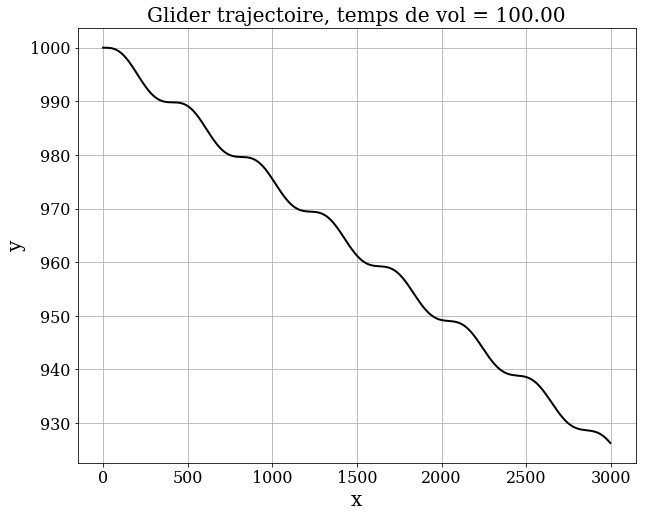

In [9]:
pyplot.figure(figsize=(10,8))
pyplot.grid(True)
pyplot.xlabel(r'x',fontsize=20)
pyplot.ylabel(r'y',fontsize=20)
pyplot.title('Glider trajectoire, temps de vol = %.2f' %T,fontsize=20)
pyplot.plot (x,y, 'k-',lw=2)

Convergence

Comme on ne connait pas la véritable solution analytique, on va étudier le comportement de la solution en choisissant plusieurs valeurs de dt différentes

In [10]:
dt_values = numpy.array([0.1,0.05,0.01,0.005,0.001])

Créons le tableau final contenant les 5 solutions u différentes. numpy.empty_like() nous crée un tableau vide qui aura la même forme que celle de l'argument

In [11]:
u_values = numpy.empty_like(dt_values,dtype=numpy.ndarray ) 
#dtype renseigne le type de donnée que le tableau va recevoir

La fonction enumerate() va permettre de ressortir à chaque fois (l'index, élément de la liste) 

In [12]:
for i, dt in enumerate(dt_values):
    
    N = int(T/dt) + 1    # nombre de steps

    #initialisation du vecteur u contenant la solution pour chaque dt
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])

    #execution de Euler
    for n in range(N-1):
       
        u[n+1] = euler_step(u[n], f, dt)
    
    #on range la solution dans notre grand tableau final
    u_values[i] = u

A présent, on va calculer les différences relatives des solutions par rapport à la meilleure (i.e. celle avec le plus petit dt)

Remarque : my_array[3:8:2] renvoie my_array[3], my_array[5] et my_array[7]
Ceci est utile car on aimerait calculer la différence entre les solutions, or celle du dt=0.1 comporte 1001 points et la meilleur (dt=0.001) en comporte 10001

In [13]:
def get_diffgrid(u_voulu,u_best,dt):
    N_voulu = len(u_voulu[:,0])
    N_best = len(u_best[:,0])
    
    ratio_taille_grille = ceil(N_best/N_voulu)  #ceil = plafond
    
    diffgrille=dt*numpy.sum(numpy.abs(u_voulu[:,2]-\
                                     u_best[::ratio_taille_grille,2]))
    return diffgrille

Remarque : on peut accéder au dernier élément d'une liste avec my_array[-1] , à l'avant-dernier avec my_array[-2], etc

In [14]:
diffgrid=numpy.empty_like(dt_values)

for i,dt in enumerate(dt_values):
    
    diffgrid[i]=get_diffgrid(u_values[i],u_values[-1],dt)

On va plotter cela en graphique log-log

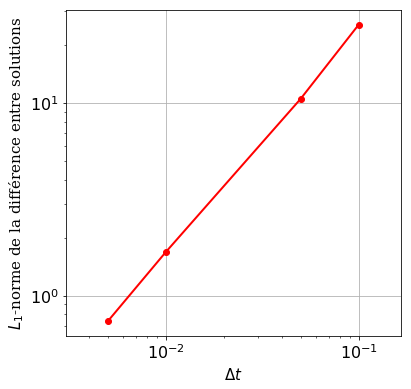

In [15]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel('$\Delta t$', fontsize=15)
pyplot.ylabel('$L_1$-norme de la différence entre solutions', fontsize=15)
pyplot.axis('equal')
pyplot.loglog(dt_values[:-1], diffgrid[:-1], color='r', ls='-', lw=2, marker='o');

Ordre de convergence

On image maintenant 3 nouvelles valeurs de dt basées sur des paramètres r et h : h, rh et r²h. Puis on recalcule tout ça avec ces nouvelles valeurs pour finalement obtenir l'ordre de convergence

In [17]:
r = 2
h = 0.001

dt_values2 = numpy.array([h, r*h, r**2*h])

u_values2 = numpy.empty_like(dt_values2, dtype=numpy.ndarray)

diffgrid2 = numpy.empty(2)

for i, dt in enumerate(dt_values2):
    
    N = int(T/dt) + 1   # number of time-steps

    # initialize the array containing the solution for each time-step
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])

    # time loop
    for n in range(N-1):

        u[n+1] = euler_step(u[n], f, dt)         ### call euler_step() ###
    
    # store the value of u related to one grid
    u_values2[i] = u
    

#calculate f2 - f1
diffgrid2[0] = get_diffgrid(u_values2[1], u_values2[0], dt_values2[1])

#calculate f3 - f2
diffgrid2[1] = get_diffgrid(u_values2[2], u_values2[1], dt_values2[2])

# calculate the order of convergence
p = (log(diffgrid2[1]) - log(diffgrid2[0])) / log(r)

print('Ordre de convergence : p = {:.3f}'.format(p));

Ordre de convergence : p = 1.014


Cet ordre est très proche de 1 : la méthode d'Euler est de premier ordre.